In [7]:
%pip install pandas spacy scikit-learn matplotlib
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.7.0-cp39-cp39-macosx_11_0_arm64.whl (7.3 MB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_11_0_arm64.whl (63 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached contourpy-1.0.7-cp39-cp39-macosx_11_0_arm64.whl (229 kB)
  Using cached Pillow-9.4.0-cp39-cp39-macosx_11_0_arm64.whl (3.0 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 10.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
pd.set_option('max_colwidth', 400)

### Набор данных
[
SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being **ham** (legitimate) or **spam**.

Ставим задачу бинарной классификации спам и неспам

переименовываем столбцы для удобной работы

In [17]:
data = pd.read_csv('spam_data.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


Хэм - норм 
спам - плохо 
Датасет `не сбалансирован`! 
так как ham сильно больше чем спам

In [12]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

кроме простой проверки количественной надо посмотреть длинну вообще сообщений слова в этих сообщениях, контент посмотреть. все это чтобы заранее понимать. мб там вообще не тот язык и некоректно работает 

здесь мы меняем хам и спам на 1 и 0

In [18]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


### Очистка

Стоп-слова для англиского языка в spaCy

проблема библиотек стоп слов, что они не специфичны 
например в книги про динозавтров, и слово динозавр является мусором и не несет нагрузку и надо его добавить в СТОП слова

In [19]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"onto just any mostly whereupon quite around whatever ours whence her further serious did ‘ll either only myself other already do top someone without although with has last fifty are them back side because herein fifteen thru though that own else until have first alone thereupon ‘s everything anything due please part can before hers there too regarding used this or ’re thence ’ll thereafter they various nothing take been below ‘d between again thus ca ‘ve ’s namely being beforehand however at sometime each ’m unless less herself whereas when all these behind above became whom some n’t were third anywhere somehow becoming than still name was and through go might very same former my indeed therefore your see by such off noone hereupon its nowhere also is well per now even really otherwise could n‘t becomes always itself had six latterly perhaps more themselves may no into whether you to nevertheless somewhere latter himself say along so thereby as everywhere yet five four few while toget

Атрибуты [Token](https://spacy.io/api/token#attributes)

Это чисто для спейси он может ! нижний регистр пунктуацию, цифры, имейл, цифры написаные прописью, пробелы

In [20]:
%%time

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if 
        not token.is_stop 
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

CPU times: user 43.9 s, sys: 300 ms, total: 44.2 s
Wall time: 44.3 s


,label,text,cleaned_text
704,0,True dear..i sat to pray evening and felt so.so i sms'd you in some time...,true dear sit pray evening feel so.so sms'd time
5039,1,Natalie (20/F) is inviting you to be her friend. Reply YES-165 or NO-165 See her: www.SMS.ac/u/natalie2k9 STOP? Send STOP FRND to 62468,natalie f invite friend reply yes-165 no-165 www.sms.ac/u/natalie2k9 stop send stop frnd
1103,0,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.,aiyah sorry lor watch tv watch forget check phone
3770,0,"Hi, wlcome back, did wonder if you got eaten by a lion or something, nothing much",hi wlcome wonder got eat lion
283,0,Okie...,okie


In [21]:
data['cleaned_text'].iloc[3]

'u dun early hor u c'

### Bag of words
мешок слов - способ векторизации 

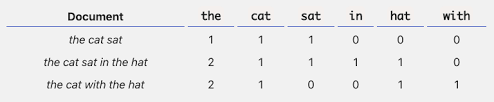

#### CountVectorizer
класс в склерн 
используются регулярные выражения

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

##### Стоп-слова

их лучшее доопределять или переопределять

In [23]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'onto any amoungst mostly whereupon around whatever ours inc whence her sincere further serious either only myself other already do fill top someone hasnt without un although with has last fifty are them bill back side because herein fifteen thru though that own else until have first alone thereupon everything anything due eg please part cry can before hers there too this or thence thereafter they nothing take been couldnt below between again thus etc ie namely being beforehand however at sometime each less herself whereas when all these behind above became whom some were third system anywhere somehow co con becoming than still name was and through go might very same former my indeed therefore thick your see by such cant off ltd noone find hereupon its nowhere also is well detail mill per now even otherwise could becomes always itself had six latterly perhaps more themselves may no into whether you to nevertheless somewhere latter fire himself along so thereby as everywhere interest ye

This list of English stop words is taken from the "Glasgow Information Retrieval Group". The original list can be found at
http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

##### Train/test split & fit

важной сделать разделение на трейн и тест перед работой 
иначе модель будет учиться по тестовой частью

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

ну типа выбираем размер мешка слов:

max_df токен свречается в 70процендах документов и выже выкидываем

 min_df токен встречается редко и выбрасываем его 

In [25]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##### Разреженное представление результата

чтобы эффективной хванить мешок слов с кучей пустот, мы применяем разреженность и метод спарс!

Поскольку в большинстве документов обычно используется очень небольшое подмножество слов, используемых в корпусе, результирующая матрица будет иметь много нулевых значений признаков (обычно более 99% из них).

Чтобы оптимально хранить такую матрицу в памяти, а также ускорить алгебраические операции с матрицей/вектором, обычно используют разреженное представление, такое как реализации, доступные в пакете scipy.sparse.


[Sparse matrices (scipy.sparse)](https://docs.scipy.org/doc/scipy/reference/sparse.html)

**CSR** - Compressed Sparse Row

**COO** - COOrdinate format

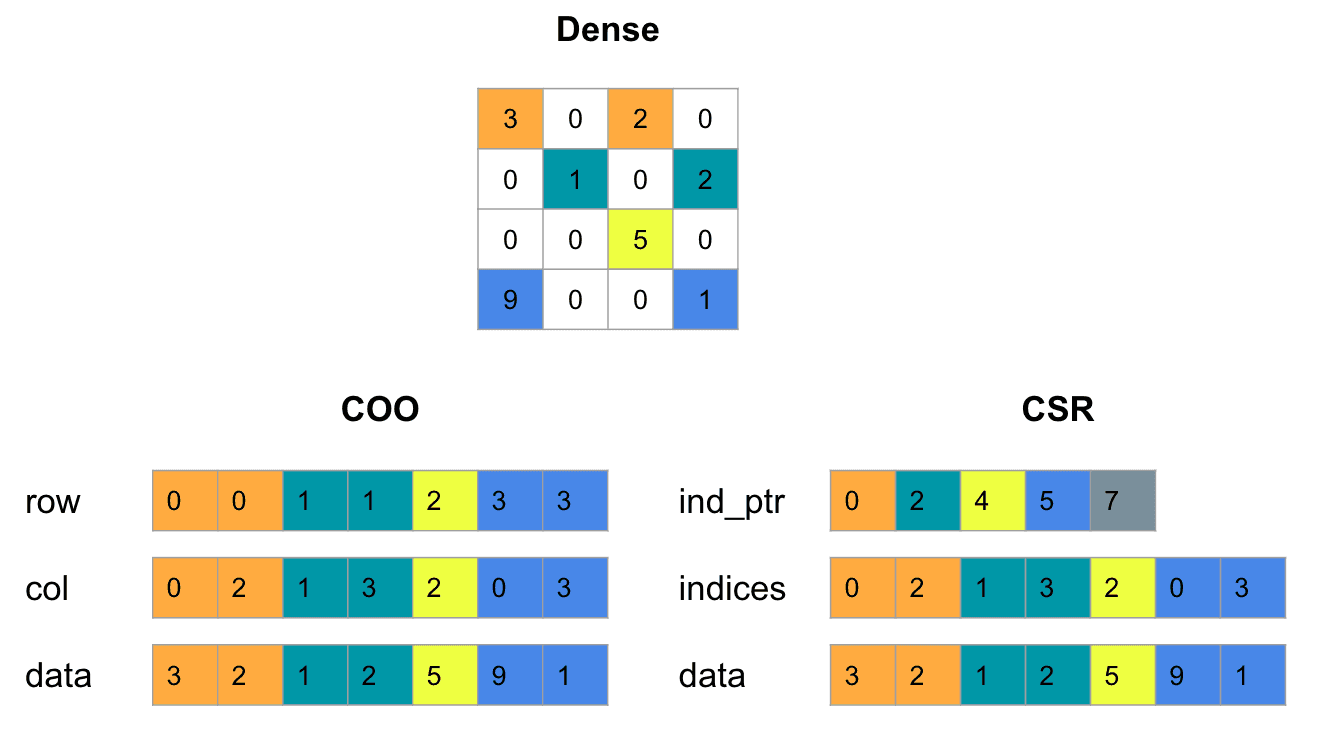

In [26]:
X_train_vectorized

<4179x449 sparse matrix of type '<class 'numpy.int64'>'
	with 18002 stored elements in Compressed Sparse Row format>

слова которые вошли в словарь

In [27]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', '1000', '10p', '150p', '150ppm', '2000', '50',
       '500', '5000', 'able', 'abt', 'account', 'actually', 'add',
       'address', 'aft', 'afternoon', 'ah', 'aight', 'alright', 'amp',
       'answer', 'anytime', 'apply', 'ard', 'ask', 'attempt', 'await',
       'award', 'away', 'babe', 'baby', 'bad', 'beautiful', 'bed',
       'believe', 'big', 'birthday', 'bit', 'bonus', 'book', 'bored',
       'box', 'boy', 'boytoy', 'break', 'bring', 'brother', 'bt', 'bus',
       'busy', 'buy', 'call', 'camera', 'car', 'card', 'care', 'cash',
       'cause', 'chance', 'change', 'charge', 'chat', 'check', 'chikku',
       'choose', 'claim', 'class', 'close', 'co', 'code', 'collect',
       'collection', 'colour', 'com', 'come', 'confirm', 'contact',
       'cool', 'cos', 'cost', 'coz', 'crazy', 'credit', 'cs', 'cum',
       'customer', 'da', 'dad', 'darlin', 'dat', 'date', 'day', 'de',
       'dear', 'decide', 'decimal', 'delivery', 'den', 'detail', 'dinner',
       'dis'

In [24]:
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,000,10,100,1000,10p,150p,150ppm,2000,50,500,...,xxx,ya,yeah,year,yes,yesterday,yo,you,yup,ìï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Бейзлайн

In [28]:
# константный бейзлайн
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Константное предсказание

Настраиваем его стратегию

и делаем предсказание

In [29]:

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
# зеро дивижн, чтобы на ноль не делить
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



Логистическая регрессия

вообще круто

In [30]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.97      0.82      0.89       186

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



##### Переопределение токенизатора, препроцессинга

чтобы заранее предобработать ну типа в ручную, опять же регулярочкой 

In [31]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [32]:
custom_vectorizer = CountVectorizer(
    max_df=0.7, 
    min_df=0.003, 
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
) 
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [33]:
X_train_vectorized

<4179x445 sparse matrix of type '<class 'numpy.int64'>'
	with 18708 stored elements in Compressed Sparse Row format>

In [34]:
pd.DataFrame(X_train_vectorized.toarray(), columns=custom_vectorizer.get_feature_names_out()).head()

,able,abt,account,actually,add,address,aft,afternoon,age,ah,...,xmas,xxx,y,ya,yeah,year,yes,yesterday,yo,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


и даже характеристики улучшились!

In [35]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1207
           1       0.99      0.83      0.90       186

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа. 

отфильтровать ненужное 

попытка оценить вес слова(токен) в нашей выборке и скоректировать векторизацию

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



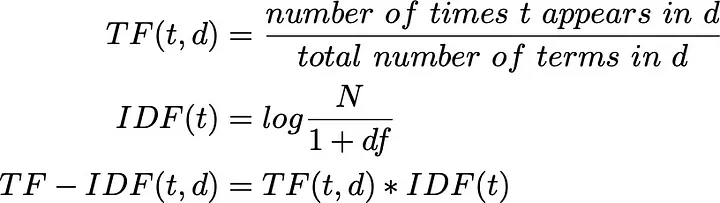

Можно заметить, что **term-frequency** изменяется в диапазоне [0, 1]

логарифм нужен чтобы сбалансировать тф-айдиф ( могут быть выбросы по отдельность)

тогда как без логарифмирования **inverse document-frequency** - [1, N + 1]

#### Отличия в реализации Sklearn

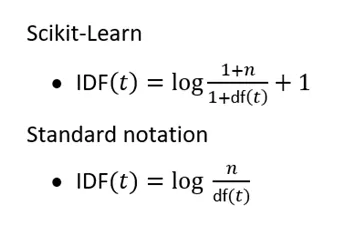

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity (косинусное расстояние - метрика для рассчета сходства/различия слов в векторной форме):
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

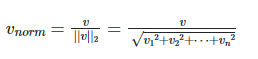

#### TfidfTransformer vs  TfidfVectorizer

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

**TfidfTransformer** преобразует матрицу из CountVectorizer в tf-idf

In [38]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



**TfidfVectorizer** работает end-to-end

происходит тоже самое что и сверху

In [39]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

In [40]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

пробуем подобрать

l1 - нормализация

l2 - евклидова норма

clf_C - коэфф регуляризации модели ( логрег )

In [45]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [42]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

`HalvingGridSearchCV` берет только подможество данных, когда как `GridSearch` берет весь набор данных

In [47]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1, # cpu
    verbose=1,
    cv=2,
    scoring='accuracy',
)
grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 8
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 8
Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1760 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_t

----------
iter: 1
n_candidates: 534
n_resources: 24
Fitting 2 folds for each of 534 candidates, totalling 1068 fits


/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [  nan   nan   nan ... 0.875 0.875 0.875]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86742424 0.86742424 0.86742424]
  warnings.warn(


----------
iter: 2
n_candidates: 178
n_resources: 72
Fitting 2 folds for each of 178 candidates, totalling 356 fits


/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.81706349 0.81706349 0.81706349]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.81746032 0.81746032 0.81746032]
  warnings.warn(


----------
iter: 3
n_candidates: 60
n_resources: 216
Fitting 2 folds for each of 60 candidates, totalling 120 fits


/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.87452406 0.87452406 0.87452406]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.87898062 0.87898062 0.87898062]
  warnings.warn(


----------
iter: 4
n_candidates: 20
n_resources: 648
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.88253927 0.88253927 0.89490406]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86398731 0.86398731 0.88407293]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.8667028 0.8667028 0.9511052]
  warnings.warn(
/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.8589841  0.8589841  0.94647345]
  warnings.warn(


----------
iter: 5
n_candidates: 7
n_resources: 1944
Fitting 2 folds for each of 7 candidates, totalling 14 fits
CPU times: user 4.68 s, sys: 377 ms, total: 5.06 s
Wall time: 8.14 s


HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    scoring='accuracy', verbose=1)

In [48]:
plt.rcParams["figure.figsize"] = (12, 8)

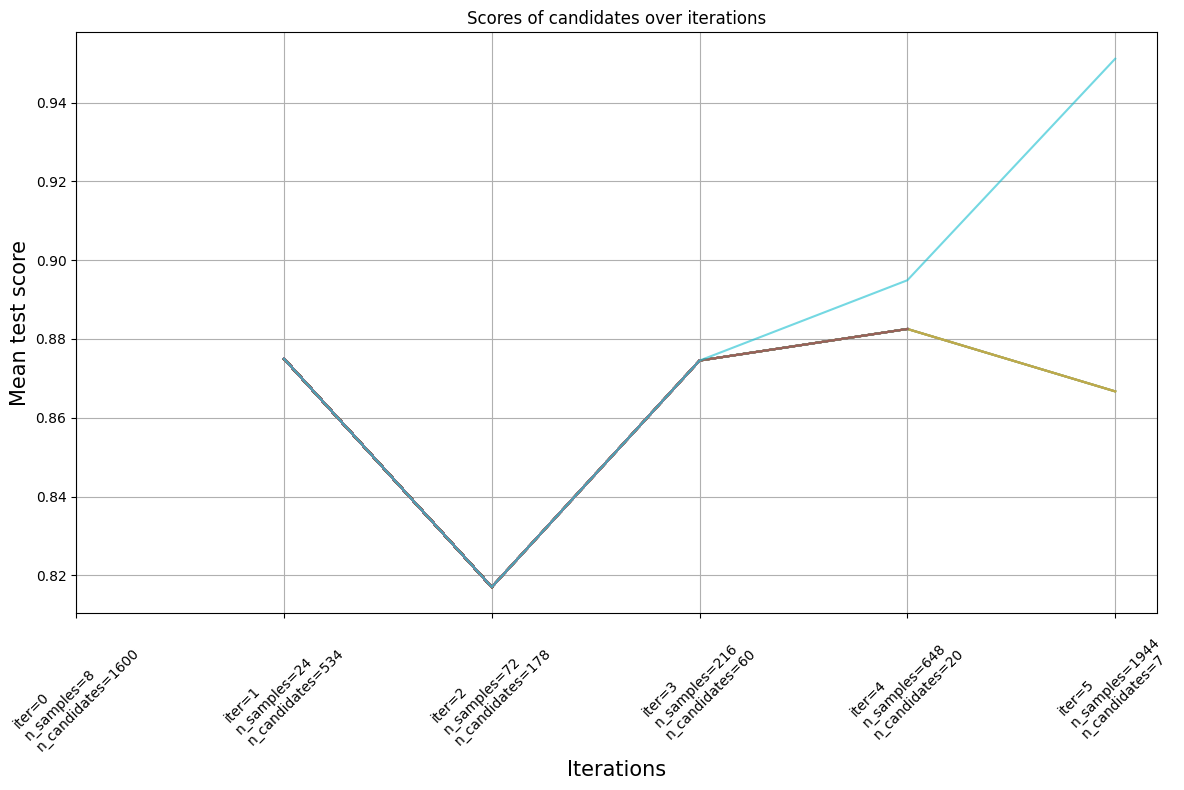

In [49]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", 
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [50]:
grid_search.best_score_

0.9511051989167334

берем лучший результат 

In [51]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.99      0.77      0.87       186

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.92      1393
weighted avg       0.97      0.97      0.97      1393



#### Визуализация & Интерпретация 

##### Altair

чтобы посмотреть все ли у нас четко получилось или нет 

[Altair](https://https://github.com/altair-viz/altair) - declarative statistical visualization library for Python

In [58]:
%pip install altair

Defaulting to user installation because normal site-packages is not writeable
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
     |████████████████████████████████| 55 kB 1.3 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [53]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenize, max_df=0.7, min_df=0.003, )
transformed = tfidf.fit_transform(X_train)

/Users/nikitav/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
tfidf_df = pd.DataFrame(transformed.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df = tfidf_df.stack().reset_index().rename(columns={0: 'tfidf', 'level_0': 'document', 'level_1': 'term', 'level_2': 'term'})
tfidf_df = tfidf_df.sort_values(by=['document', 'tfidf'], ascending=[True, False]).groupby(['document']).head()
tfidf_df.head()

,document,term,tfidf
284,0,place,0.884920
213,0,lot,0.465743
0,0,able,0.000000
1,0,abt,0.000000
2,0,account,0.000000


In [55]:
tfidf_df.sort_values(by='tfidf', ascending=False).head(100)

,document,term,tfidf
940677,2113,u,1.0
661088,1485,ok,1.0
102372,230,b,1.0
1778160,3995,touch,1.0
103161,231,tell,1.0
...,...,...,...
559804,1257,yeah,1.0
1415357,3180,not,1.0
1100642,2473,happen,1.0
1391220,3126,guess,1.0


In [56]:
tfidf_df.iloc[100:200]

,document,term,tfidf
9340,20,year,0.576344
9058,20,happy,0.560810
9149,20,new,0.506715
9292,20,u,0.310741
8900,20,able,0.000000
...,...,...,...
17686,39,send,0.757523
17639,39,place,0.341287
17593,39,money,0.340000
17723,39,text,0.268107


In [59]:
import altair as alt

In [60]:
# выделяем
term_list = ['free', 'money']

top_tfidf_df = tfidf_df[tfidf_df['tfidf'] != 0]

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_df.iloc[300:400]).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600) #circle

alt.LayerChart(...)

##### ELI5

[eli5](https://eli5.readthedocs.io/en/latest/) - Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.

In [61]:
%pip install eli5

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 216 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.4 MB/s  eta 0:00:01
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c91f503c97a6e023e80b317130b81523448e4ab495f3b1239c450a6bed527144
  Stored in directory: /Users/nikitav/Library/Caches/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [62]:
import eli5

Интерпретируем логистическую регрессию

In [63]:
grid_search.best_estimator_['clf']

LogisticRegression()

In [64]:
eli5.show_weights(
    estimator=grid_search.best_estimator_['clf'], 
    feature_names= list(grid_search.best_estimator_['counter'].get_feature_names_out()),
    top=(50, 5)
)

Weight?,Feature
+4.363,txt
+3.853,claim
+3.712,mobile
+3.431,www
+3.273,150p
+3.214,win
+3.050,free
+3.049,service
+2.982,stop
+2.857,chat
